author: Łukasz Szymczyk (szymczyklp@gmail.com) <br>
date: 2021-08-30

# Packages

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
from IPython.display import clear_output

from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.formula.api import ols

# DataIn

In [2]:
path = r'D:/MSI_BACKUP/SCIENCE/PhD/ART/4_liq_risk/data/'
#file = r'US high yield bond MFs 2000-2021.07_only surviving.xlsx' #(1)
file = r'US high yield bond MFs 2000-2021.07_non surviving included2.xlsx' #(2)
data_excel = pd.ExcelFile(path + 'in/' + file)
#print(data_excel.sheet_names)
#returns_funds = data_excel.parse('US HY bond MF only surv') #(1)
returns_funds = data_excel.parse('US HY bond MF oldest share') #(2)

In [3]:
spx = pd.read_csv(path + 'in/' + '^spx_m.csv', sep = ',', decimal = '.')

# RegEx

In [4]:
pattern_period = re.compile(r'^(Monthly Return) ([0-9]{4}-[0-9]{2}) (Base Currency)$')

# Functions

In [5]:
def period_extraction(kol_in,pattern):
    '''
    Extractin period from data description
    '''
    try:
        re.search(pattern,kol_in).group(0)
        kol_out = re.search(pattern,kol_in).group(2)
        kol_out = pd.to_datetime(kol_out)
        kol_out = kol_out + relativedelta(months=1, days=-1) 
        return kol_out
    except AttributeError:
        return None


# Hyperparameters

In [6]:
window = 36
date_start = pd.to_datetime('2000-01-31')

# DataPrep

In [7]:
#print(list(data_df.columns.values))
my_column = ['Ticker'] + [s for s in list(returns_funds.columns.values) if 'Monthly Return' in s]
returns_funds = returns_funds.loc[:,my_column]
returns_funds = returns_funds.set_index('Ticker')
returns_funds = returns_funds.transpose()
returns_funds = returns_funds.reset_index()
returns_funds = returns_funds.rename(columns={'index': 'Period'})
returns_funds['Period'] = np.vectorize(period_extraction)(returns_funds['Period'],pattern_period)
returns_funds = returns_funds.set_index('Period')
#returns_funds.iloc[:,92].plot()
returns_funds.tail(5)

Ticker,TNHIX,AGDAX,HIYYX,BJBHX,AUYIX,FYAIX,HYAAX,CHIIX,AHYFX,_NT001,...,SSTHX,SHYOX,SIHYX,WAHYX,SHIAX,LMECX,WHGHX,_NT133,WPINX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2021-03-31,0.33751,-0.36801,0.20891,0.24433,NaN,0.36823,NaN,0.78071,NaN,NaN,...,0.31467,-0.37157,NaN,0.30722,0.60823,-1.80893,0.62769,NaN,9.21739,0.04164
2021-04-30,0.76689,1.79531,1.46004,1.02430,NaN,1.29430,NaN,1.62384,NaN,NaN,...,0.66633,1.48610,NaN,1.23443,1.13809,2.95376,1.70453,NaN,5.25478,0.35818
2021-05-31,0.21088,0.58806,0.48256,0.34816,NaN,0.33465,NaN,-0.04927,NaN,NaN,...,0.30525,0.68303,NaN,0.28036,0.39009,2.21011,1.13976,NaN,1.96672,0.58489
2021-06-30,0.92130,1.27223,1.31594,1.00831,NaN,0.47027,NaN,2.03663,NaN,NaN,...,0.54679,0.97664,NaN,1.50087,0.90982,0.36977,1.53892,NaN,0.14837,0.52219
2021-07-31,0.12526,0.38836,0.41769,-0.16393,NaN,0.03040,NaN,0.11954,NaN,NaN,...,-0.06594,0.06681,NaN,0.30565,-0.00786,0.10834,-0.07469,NaN,-0.88889,0.26056


In [8]:
b = 0
dodrop = []
B = len(returns_funds.columns) -1

for col_name in returns_funds.columns:
    clear_output(wait = True)
    print(col_name + ' :     ' + str(b) + ' / ' + str(B))
    
    if sum(pd.notna(returns_funds.loc[:,col_name])) == 0:
        dodrop.append(col_name)
    
    b = b + 1
    
returns_funds = returns_funds.drop(columns = dodrop)
print(dodrop)

ZEOIX :     347 / 347
['HYAAX', '_NT008', '_NT013', '_NT015', 'BSIHX', '_NT016', '_NT020', '_NT022', '_NT023', '_NT025', '_NT031', 'FIFJX', '_NT034', '_NT035', '_NT037', '_NT039', 'HNRZX', '_NT045', '_NT046', '_NT047', '_NT064', '_NT068', '_NT070', 'MWOPX', '_NT072', '_NT073', '_NT078', '_NT079', 'OPPHX', '_NT083', '_NT085', '_NT086', '_NT087', '_NT091', '_NT092', '_NT095', '_NT098', '_NT099', '_NT102', '_NT104', '_NT107', '_NT110', '_NT113', '_NT114', '_NT116', '_NT119', '_NT122', '_NT131']


In [9]:
spx['returns0'] = spx['Zamkniecie'].pct_change()
spx = pd.DataFrame(spx)
spx = spx.rename(columns={'Data': 'Period'})
spx['Period'] = pd.to_datetime(spx['Period'])
spx = spx.set_index('Period')
spx = spx.loc[spx.index >= date_start + relativedelta(months=-3)]
spx['returns1'] = spx['returns0'].shift(periods=1)
spx['returns2'] = spx['returns0'].shift(periods=2)
spx['returns3'] = spx['returns0'].shift(periods=3)
spx = spx.loc[spx.index >= date_start]
spx = spx.loc[:,('returns0','returns1','returns2','returns3')]
spx

,returns0,returns1,returns2,returns3
Period,,,,
2000-01-31,-0.050904,0.057722,0.019179,0.062539
2000-02-29,-0.020108,-0.050904,0.057722,0.019179
2000-03-31,0.096720,-0.020108,-0.050904,0.057722
2000-04-30,-0.030796,0.096720,-0.020108,-0.050904
2000-05-31,-0.021887,-0.030796,0.096720,-0.020108
...,...,...,...,...
2021-03-31,0.042439,0.026091,-0.011137,0.037121
2021-04-30,0.052425,0.042439,0.026091,-0.011137
2021-05-31,0.005487,0.052425,0.042439,0.026091


# AR(1)

In [10]:
funds_AR_const = returns_funds.iloc[0:-window,:]
funds_AR_const = funds_AR_const.truncate(after = 0)
funds_AR_coef = funds_AR_const

In [11]:
%%time

b = 0
B = len(returns_funds.columns) -1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in returns_funds.columns:
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))
        
        for j in range(len(returns_funds) - window):
            current_period = returns_funds.index[j]
            
            if not (pd.isna(returns_funds.loc[:,col_name].iloc[j])) and not(pd.isna(returns_funds.loc[:,col_name].iloc[j + window])):
                simulated_data = returns_funds.loc[:,col_name].iloc[j:(j+window)]
                mod = ARMA(simulated_data, order=(1,0))
                result = mod.fit()
                funds_AR_const.loc[current_period,col_name] = result.params[0]
                funds_AR_coef.loc[current_period,col_name] = result.params[1]
            else:
                funds_AR_const.loc[current_period,col_name] = float('NaN')
                funds_AR_coef.loc[current_period,col_name] = float('NaN')
                
        b = b+1


ZEOIX :     299 / 299
Wall time: 7min 55s


D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001BEA9B20AC0> has a label of '_NT021' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


<AxesSubplot:xlabel='Period'>

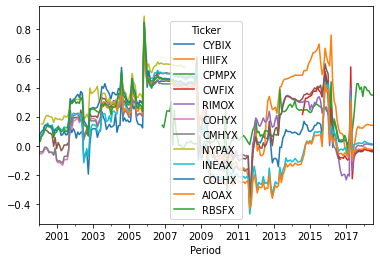

In [12]:
funds_AR_coef.iloc[:,45:58].plot()

D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001BEA9D1CA60> has a label of '_NT001' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001BEA9D3BA30> has a label of '_NT002' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001BEA9CC0C70> has a label of '_NT003' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001BEA9D3B8B0> has a label o

<AxesSubplot:xlabel='Period'>

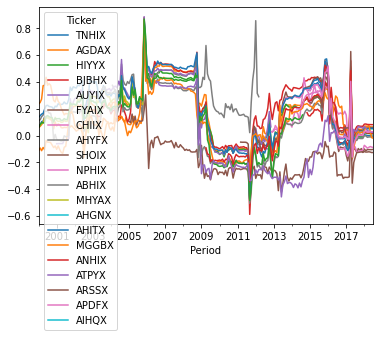

In [13]:
funds_AR_coef.iloc[:,0:30].plot()

# LagEfects

In [14]:
benchmark = pd.DataFrame(spx)
#benchmark.plot()
dataset = benchmark.join(returns_funds)
dataset.head()

,returns0,returns1,returns2,returns3,TNHIX,AGDAX,HIYYX,BJBHX,AUYIX,FYAIX,...,SSTHX,SHYOX,SIHYX,WAHYX,SHIAX,LMECX,WHGHX,_NT133,WPINX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2000-01-31,-0.050904,0.057722,0.019179,0.062539,NaN,-1.18014,NaN,NaN,NaN,NaN,...,0.25545,-0.72785,-1.17035,NaN,-0.29594,NaN,NaN,NaN,NaN,NaN
2000-02-29,-0.020108,-0.050904,0.057722,0.019179,NaN,7.18832,NaN,NaN,NaN,NaN,...,0.49057,1.29828,0.00000,NaN,0.49920,NaN,NaN,NaN,NaN,NaN
2000-03-31,0.096720,-0.020108,-0.050904,0.057722,NaN,4.10514,NaN,NaN,NaN,NaN,...,-0.31741,-1.27273,-2.10526,NaN,-2.11208,NaN,NaN,NaN,NaN,NaN
2000-04-30,-0.030796,0.096720,-0.020108,-0.050904,NaN,-2.45111,NaN,NaN,NaN,NaN,...,0.20503,-0.75492,-0.13441,NaN,-0.30905,NaN,NaN,NaN,NaN,NaN
2000-05-31,-0.021887,-0.030796,0.096720,-0.020108,NaN,-3.64045,NaN,NaN,NaN,NaN,...,0.06149,-1.65924,-1.21131,NaN,-1.77188,NaN,NaN,NaN,NaN,NaN


In [ ]:
#b = 0
#B = len(returns_funds.columns) -1
#
#for col_name in dataset.columns[4:]:
#    clear_output(wait = True)
#    print(col_name + ' :     ' + str(b) + ' / ' + str(B))
#    new_col_name = col_name.replace(" ", "_")
#    dataset = dataset.rename(columns={col_name: new_col_name})    

In [15]:
beta = pd.DataFrame({'Ticker' : [np.nan], 'Lagg' : [np.nan], 'CAMP' : [np.nan]}).dropna()

In [16]:
b = 0
B = len(returns_funds.columns) -1

for col_name in dataset.columns[5:]:
    clear_output(wait = True)
    print(col_name + ' :     ' + str(b) + ' / ' + str(B))
    
    str_camp = str(col_name) + ' ~ returns0'
    camp = ols(str_camp, data = dataset)
    camp = camp.fit()
    beta_camp = camp.params[1]    
    
    str_lagg = str(col_name) + ' ~ returns0 + returns1 + returns2 + returns3'
    lagg = ols(str_lagg, data=dataset)
    lagg = lagg.fit()
    beta_lagg = lagg.params[1] + lagg.params[2] + lagg.params[3] + lagg.params[4]
    
    beta = beta.append({'Ticker' : col_name, 'Lagg': beta_lagg, 'CAMP' : beta_camp}, ignore_index=True)
    
    b = b+1

ZEOIX :     298 / 299


In [17]:
beta['diff'] = beta['Lagg'] - beta['CAMP']
beta.head(10)

,Ticker,Lagg,CAMP,diff
0,AGDAX,44.081554,46.668107,-2.586553
1,HIYYX,49.481680,48.684232,0.797448
2,BJBHX,47.854942,44.700771,3.154171
3,AUYIX,34.726614,35.398570,-0.671956
4,FYAIX,39.075001,40.265318,-1.190318
5,CHIIX,36.646307,30.769939,5.876368
6,AHYFX,55.218147,52.324983,2.893164
7,_NT001,78.359506,43.675652,34.683854
8,_NT002,-49.701168,-3.826191,-45.874977
9,_NT003,40.293473,41.389216,-1.095743


# DataOut

In [18]:
funds_AR_const.to_csv(path + 'out/' + r'funds_AR1_const.csv', sep=';', encoding = 'windows-1250')
funds_AR_coef.to_csv(path + 'out/' + r'funds_AR1_coef.csv', sep=';', encoding = 'windows-1250')
beta.to_csv(path + 'out/' + r'funds_lagg_betas.csv', sep=';', encoding = 'windows-1250')